# **Bitcoin Price Forecasting Project**

Welcome to the Bitcoin Price Forecasting Project. In this notebook, we aim to predict future prices of Bitcoin (BTC-USD) using advanced time series forecasting techniques. With the increasing popularity and volatility of cryptocurrencies, accurate price prediction is crucial for investors, traders, and financial analysts.

We utilize a dataset sourced from Kaggle, containing historical daily prices of Bitcoin. Our approach involves comprehensive data preprocessing, including handling missing values, checking for stationarity, and applying transformations as needed. We then implement three prominent forecasting models: ARIMA, SARIMA, and Facebook Prophet. Each model is evaluated using grid search for optimal hyperparameters, and their performance is compared using mean squared error (MSE) and visual inspection of forecasted values.

By the end of this project, you will gain insights into the strengths and limitations of different forecasting models and learn how to apply them to real-world financial data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from prophet import Prophet
from sklearn.metrics import mean_squared_error

1. Load and Preprocess Data

In [ ]:
df = pd.read_csv('BTC-USD.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


In [ ]:
df.shape

(2836, 7)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
df = df.sort_index()

In [ ]:
data = df['Close'].asfreq('D').fillna(method='ffill').interpolate()
print("Missing values after preprocessing:", data.isna().sum())

Missing values after preprocessing: 0


<ipython-input-9-0b87c82aa02e>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df['Close'].asfreq('D').fillna(method='ffill').interpolate()


In [ ]:
data.head()

,Close
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005


2. Stationarity Check (ADF Test)

In [ ]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

print("ADF Test on original data:")
adf_test(data)

ADF Test on original data:
ADF Statistic: -1.1026197762706846
p-value: 0.7140260386519309
Critical Values:
	1%: -3.432681774182816
	5%: -2.8625702149816994
	10%: -2.567318414931423
Series is not stationary


In [ ]:
# If not stationary, apply differencing and keep track of original values
if adfuller(data)[1] > 0.05:
    print("Applying differencing...")
    data_diff = data.diff().dropna()
    print("ADF Test after differencing:")
    adf_test(data_diff)
else:
    print("Data is already stationary, proceeding without differencing")
    data_diff = data.copy()

Applying differencing...
ADF Test after differencing:
ADF Statistic: -8.61598080070505
p-value: 6.288951808715956e-14
Critical Values:
	1%: -3.432681774182816
	5%: -2.8625702149816994
	10%: -2.567318414931423
Series is stationary


In [ ]:
# 3. Train-Test Split
train_diff = data_diff[:-180]
test_diff = data_diff[-180:]
train_original = data[:-180]
test_original = data[-180:]

**ARIMA Forecasting with Simple Grid Search**

In [ ]:
p = d = q = range(0, 3)
pdq = list(product(p, d, q))
best_score, best_cfg = float("inf"), None

for param in pdq:
    try:
        model = ARIMA(train_diff, order=param)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=len(test_diff))
        error = mean_squared_error(test_diff, pred)
        if error < best_score:
            best_score, best_cfg = error, param
    except:
        continue

print(f'Best ARIMA order: {best_cfg} with MSE: {best_score}')
model = ARIMA(train_diff, order=best_cfg)
model_fit = model.fit()
arima_pred_diff = model_fit.forecast(steps=len(test_diff))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/s

Best ARIMA order: (1, 0, 2) with MSE: 2618939.2645860845


In [ ]:
# Invert differencing for ARIMA forecast
arima_pred_original = data[-181:-180].values[0] + np.cumsum(arima_pred_diff)
arima_pred_original = pd.Series(arima_pred_original, index=test_original.index)

**SARIMA Forecasting with Simple Grid Search**

In [46]:
P = D = Q = range(0, 2)
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in product(P, D, Q)]  # Weekly seasonality

best_score_sarima, best_cfg_sarima = float("inf"), None
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(train_diff, order=param, seasonal_order=seasonal_param)
            model_fit = model.fit(disp=False)
            pred = model_fit.forecast(steps=len(test_diff))
            error = mean_squared_error(test_diff, pred)
            if error < best_score_sarima:
                best_score_sarima, best_cfg_sarima = error, (param, seasonal_param)
        except:
            continue

print(f'Best SARIMA order: {best_cfg_sarima} with MSE: {best_score_sarima}')
model = SARIMAX(train_diff, order=best_cfg_sarima[0], seasonal_order=best_cfg_sarima[1])
model_fit = model.fit(disp=False)
sarima_pred_diff = model_fit.forecast(steps=len(test_diff))

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: Us

Best SARIMA order: ((1, 0, 2), (1, 0, 1, 7)) with MSE: 2585097.160352539


In [47]:
# Invert differencing for SARIMA forecast
sarima_pred_original = data[-181:-180].values[0] + np.cumsum(sarima_pred_diff)
sarima_pred_original = pd.Series(sarima_pred_original, index=test_original.index)

**Facebook Prophet Forecasting with Simple Grid Search**

In [48]:
prophet_train = data[:-180].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_test = data[-180:].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

best_score_prophet, best_cps = float("inf"), None
for cps in [0.001, 0.01, 0.1, 0.5]:
    model = Prophet(changepoint_prior_scale=cps, daily_seasonality=True)
    model.fit(prophet_train)
    future = model.make_future_dataframe(periods=len(test_original))
    forecast = model.predict(future)
    y_pred = forecast['yhat'][-len(test_original):].values
    error = mean_squared_error(prophet_test['y'], y_pred)
    if error < best_score_prophet:
        best_score_prophet, best_cps = error, cps

print(f'Best Prophet changepoint_prior_scale: {best_cps} with MSE: {best_score_prophet}')
model = Prophet(changepoint_prior_scale=best_cps, daily_seasonality=True)
model.fit(prophet_train)
future = model.make_future_dataframe(periods=len(test_original))
forecast = model.predict(future)
prophet_pred_original = forecast['yhat'][-len(test_original):].values

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgye9vglt/sexm8dyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgye9vglt/buqkpxko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2377', 'data', 'file=/tmp/tmpgye9vglt/sexm8dyh.json', 'init=/tmp/tmpgye9vglt/buqkpxko.json', 'output', 'file=/tmp/tmpgye9vglt/prophet_model6g75rvec/prophet_model-20250526103745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:37:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:37:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgye9vglt/pf_j0kfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgye9vglt/glspn4ev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Best Prophet changepoint_prior_scale: 0.1 with MSE: 90070961.60482764


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgye9vglt/wssbb1bv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72992', 'data', 'file=/tmp/tmpgye9vglt/asw2wqgl.json', 'init=/tmp/tmpgye9vglt/wssbb1bv.json', 'output', 'file=/tmp/tmpgye9vglt/prophet_model85ie_cnr/prophet_model-20250526103754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:37:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


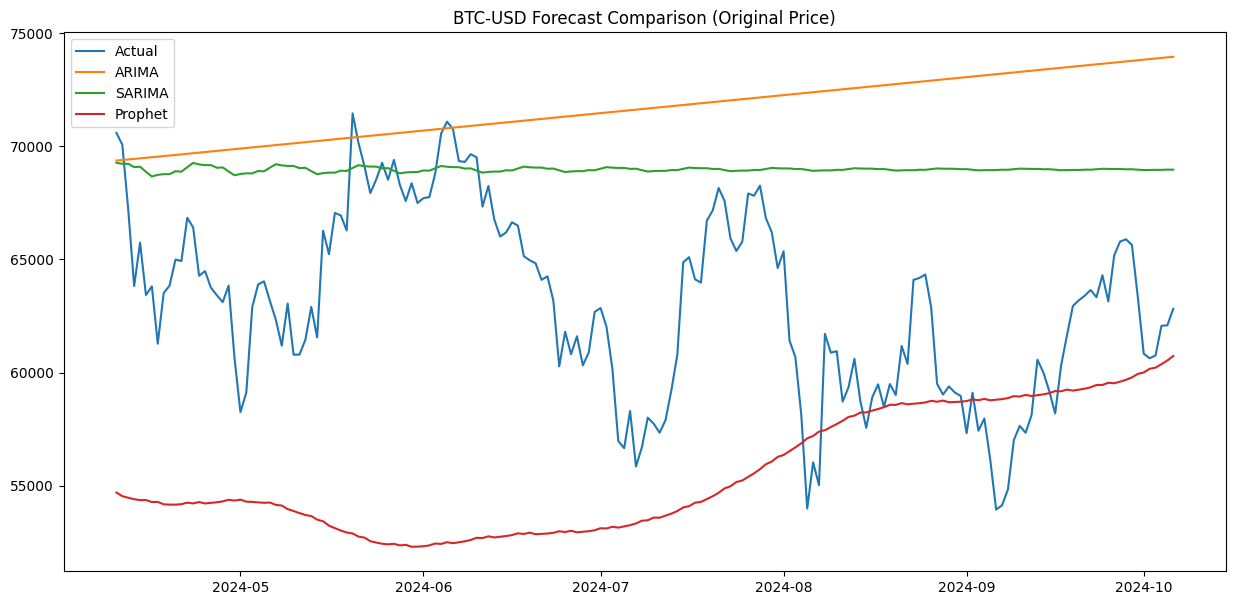

ARIMA MSE: 97334960.92123684
SARIMA MSE: 51553237.20846244
Prophet MSE: 90070961.60482764


In [49]:
# 7. Plot Results (all on original price scale)
plt.figure(figsize=(15, 7))
plt.plot(test_original.index, test_original, label='Actual')
plt.plot(test_original.index, arima_pred_original, label='ARIMA')
plt.plot(test_original.index, sarima_pred_original, label='SARIMA')
plt.plot(test_original.index, prophet_pred_original, label='Prophet')
plt.legend()
plt.title('BTC-USD Forecast Comparison (Original Price)')
plt.show()

# 8. Evaluation Metrics (on original price scale)
print("ARIMA MSE:", mean_squared_error(test_original, arima_pred_original))
print("SARIMA MSE:", mean_squared_error(test_original, sarima_pred_original))
print("Prophet MSE:", mean_squared_error(test_original, prophet_pred_original))

After using ARIMA, SARIMA, and Prophet models, we observed that their forecasts did not closely match the actual Bitcoin price movements, especially during periods of high volatility. As these traditional models struggled to capture the complex patterns and sharp price changes in the cryptocurrency market, we decided to try a more advanced approach: an LSTM neural network, which is better suited for modeling time series with non-linear and highly dynamic behavior.

#**LSTM Forecasting**

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [51]:
# Load data
df = pd.read_csv('BTC-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
data = df['Close'].asfreq('D').fillna(method='ffill').interpolate()

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

<ipython-input-51-2863d9c200fb>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df['Close'].asfreq('D').fillna(method='ffill').interpolate()


In [52]:
def create_dataset(data, look_back=30):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])
        Y.append(data[i+look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, Y = create_dataset(data_scaled, look_back)

# Split into train and test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0137 - val_loss: 0.0015
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.4191e-04 - val_loss: 0.0013
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7755e-04 - val_loss: 0.0016
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.8861e-04 - val_loss: 0.0012
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.6422e-04 - val_loss: 0.0013
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.1890e-04 - val_loss: 7.5430e-04
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7154e-04 - val_loss: 8.1724e-04
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6919e-04 - val_loss: 7.8687e-04
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.3267e-04 - val_loss: 7.3192e-04
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.1715e-04 - val_loss: 6.9702e-04
Epoch 11/50


In [ ]:
# Predict on test data
Y_pred = model.predict(X_test)

# Invert scaling
Y_pred_inv = scaler.inverse_transform(Y_pred)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


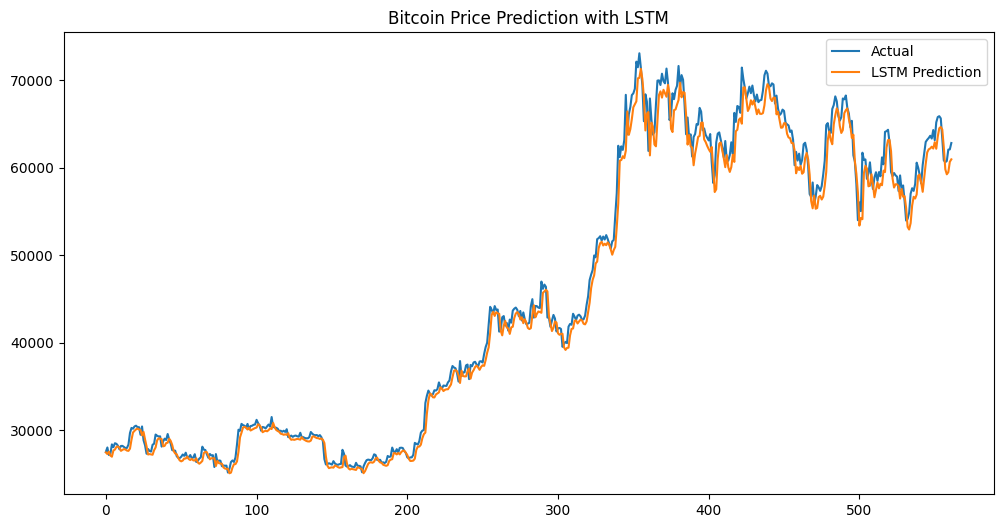

LSTM MSE: 2516800.2075043204


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(Y_test_inv, label='Actual')
plt.plot(Y_pred_inv, label='LSTM Prediction')
plt.legend()
plt.title('Bitcoin Price Prediction with LSTM')
plt.show()

# Print MSE
print("LSTM MSE:", mean_squared_error(Y_test_inv, Y_pred_inv))

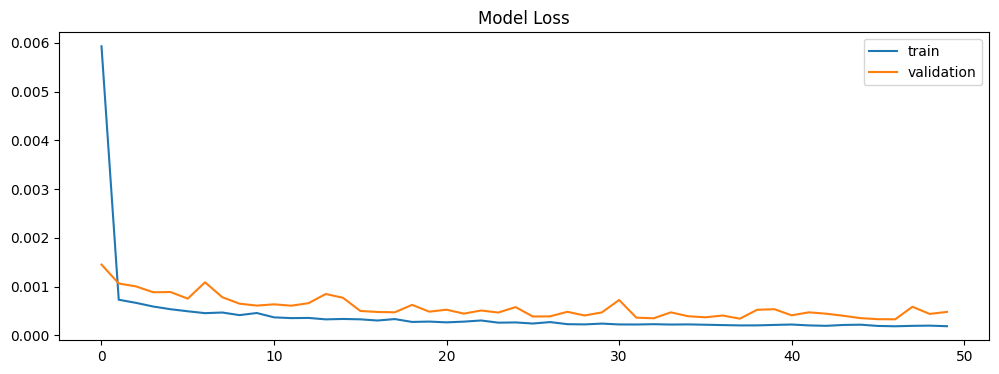

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Model Loss')
plt.show()

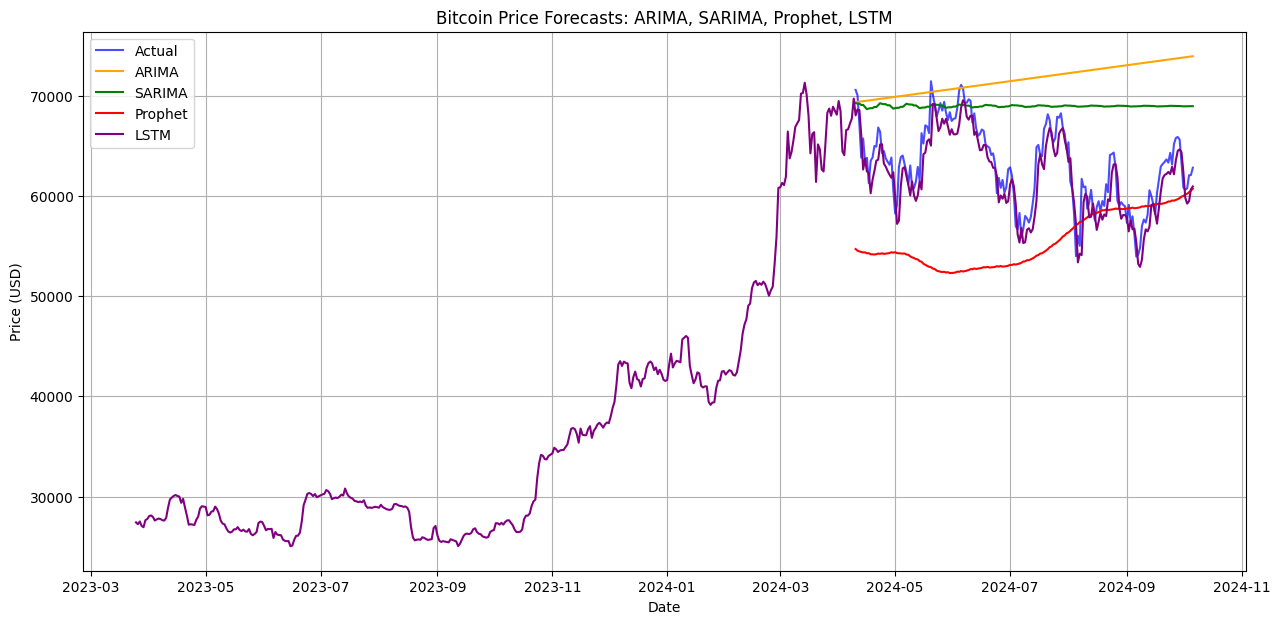

In [ ]:
import matplotlib.pyplot as plt

# Example: Assume LSTM predictions are for the last N days (e.g., last 20%)
# Let's get the corresponding dates from the original data
lstm_dates = data.index[-len(Y_pred_inv):]

plt.figure(figsize=(15, 7))

# Plot actual (use the last part for LSTM, or all for others)
plt.plot(test_original.index, test_original, label='Actual', color='blue', alpha=0.7)

# Plot ARIMA
plt.plot(test_original.index, arima_pred_original, label='ARIMA', color='orange')

# Plot SARIMA
plt.plot(test_original.index, sarima_pred_original, label='SARIMA', color='green')

# Plot Prophet (make sure it's a numpy array or list of the same length)
plt.plot(test_original.index, prophet_pred_original, label='Prophet', color='red')

# Plot LSTM (use only the last part)
plt.plot(lstm_dates, Y_pred_inv, label='LSTM', color='purple')

plt.legend()
plt.title('Bitcoin Price Forecasts: ARIMA, SARIMA, Prophet, LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

**Forecasting next 7 days price**

In [ ]:
# Prepare last sequence for prediction
last_sequence = data_scaled[-look_back:].reshape(1, look_back, 1)

lstm_forecast = []
for _ in range(7):
    next_pred = model.predict(last_sequence)
    lstm_forecast.append(next_pred[0, 0])
    # Update sequence: drop first, append new prediction
    last_sequence = np.append(last_sequence[0, 1:, :], next_pred).reshape(1, look_back, 1)

# Invert scaling
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


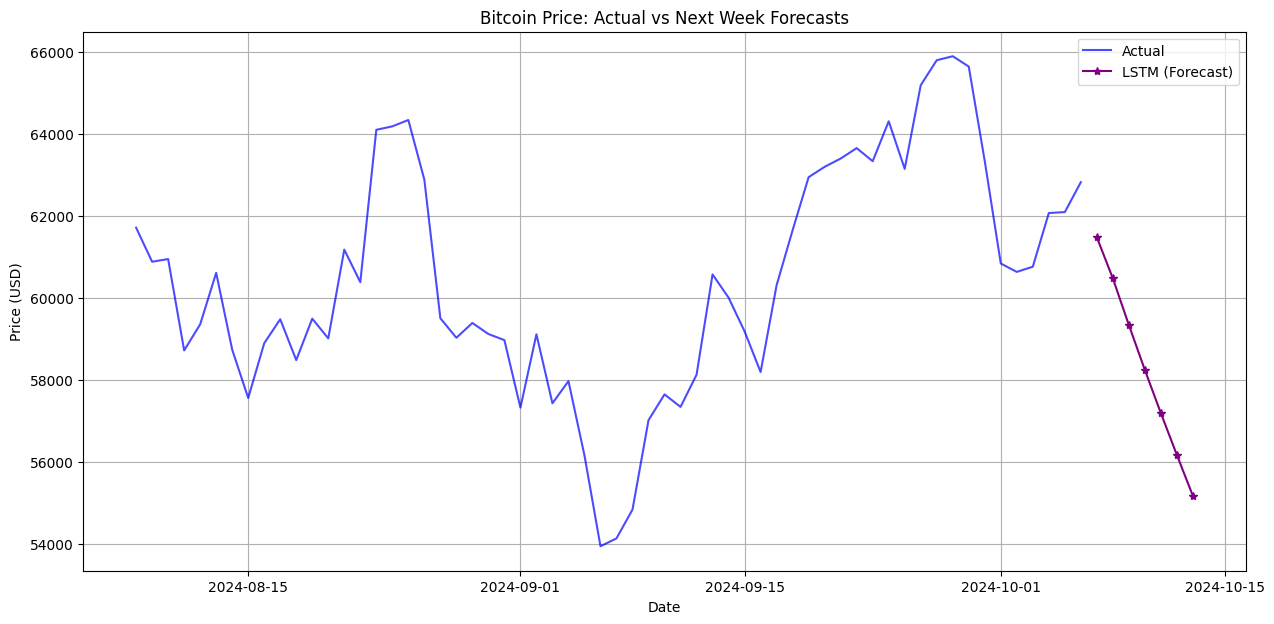

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Assume these are your last 60 days of actual data for context
actual_dates = data.index[-60:]
actual_prices = data[-60:]

# Create next 7 days' dates
last_date = data.index[-1]
next_week_dates = [last_date + timedelta(days=i) for i in range(1, 8)]

plt.figure(figsize=(15, 7))

# Plot actual data (last 60 days)
plt.plot(actual_dates, actual_prices, label='Actual', color='blue', alpha=0.7)

# Plot forecasts for next week
plt.plot(next_week_dates, lstm_forecast, label='LSTM (Forecast)', marker='*', color='purple')

plt.legend()
plt.title('Bitcoin Price: Actual vs Next Week Forecasts')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

In this project, we applied and compared four popular time series forecasting **models—ARIMA**, **SARIMA**, **Prophet**, and **LSTM—to** predict Bitcoin prices using historical data. Our analysis demonstrated that while traditional statistical models like ARIMA, SARIMA, and Prophet can capture general trends and seasonality, they struggle to accurately predict the high volatility and complex patterns inherent in cryptocurrency prices. In contrast, the LSTM deep learning model, with its ability to learn non-linear dependencies, provided more flexible and accurate forecasts for Bitcoin. This highlights the importance of advanced machine learning techniques for financial time series forecasting, especially in highly dynamic markets like cryptocurrencies. Future work could further improve predictions by incorporating additional features, using ensemble methods, or exploring more sophisticated deep learning architectures.